# long-short-portfolio

On the first trading day of every month, rebalance portfolio to given percentages.  One of the positions is a short position.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Define Portfolios

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
portfolio_option = {'SPY': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}

directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}

Some global data

In [4]:
symbols = list(portfolio_option.keys())
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

In [5]:
options = {
    'use_adj' : True,
    'use_cache' : True,
}
options

{'use_adj': True, 'use_cache': True}

In [6]:
# Fetch timeseries
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, fields=['close'],
                                use_cache=options['use_cache'], use_adj=options['use_adj'])
# Add calendar columns
ts = portfolio.calendar(ts)

# Finalize timeseries
ts, start = portfolio.finalize_timeseries(ts, start)

# Init trade logs
portfolio.init_trade_logs(ts)

In [7]:
pf.TradeLog.cash = capital

# Trading algorithm
for i, row in enumerate(ts.itertuples()):

    end_flag = pf.is_last_row(ts, i)
    
    # Rebalance on the first trading day of each month
    if row.first_dotm or end_flag:

        portfolio.print_holdings(row)
        
        # If last row, then zero out all weights.  Otherwise use portfolio_option weights.
        weights = portfolio_option if not end_flag else pf.set_dict_values(portfolio_option, 0)
        
        # Adjust weights of all symbols in portfolio
        portfolio.adjust_percents(row, weights, field='close', directions=directions)

    # Record daily balance.
    portfolio.record_daily_balance(row)

2004-12-01 TLT:  0 GLD:  0 SPY:  0 TLT_SHRT:  0 cash: 10,000.00 total: 10,000.00
2005-01-03 TLT: 64 GLD: 22 SPY: 60 TLT_SHRT: 21 cash:   133.67 total: 10,076.39
2005-02-01 TLT: 63 GLD: 23 SPY: 60 TLT_SHRT: 21 cash:   138.53 total: 10,061.63
2005-03-01 TLT: 61 GLD: 23 SPY: 61 TLT_SHRT: 20 cash:   198.74 total: 10,157.88
2005-04-01 TLT: 62 GLD: 23 SPY: 60 TLT_SHRT: 20 cash:   233.74 total: 10,003.90
2005-05-02 TLT: 61 GLD: 23 SPY: 61 TLT_SHRT: 20 cash:   201.04 total: 10,036.11
2005-06-01 TLT: 59 GLD: 23 SPY: 62 TLT_SHRT: 19 cash:   263.73 total: 10,270.57
2005-07-01 TLT: 58 GLD: 24 SPY: 61 TLT_SHRT: 19 cash:   358.40 total: 10,272.00
2005-08-01 TLT: 58 GLD: 24 SPY: 61 TLT_SHRT: 19 cash:   358.40 total: 10,404.93
2005-09-01 TLT: 61 GLD: 24 SPY: 60 TLT_SHRT: 20 cash:   239.95 total: 10,450.47
2005-10-03 TLT: 59 GLD: 23 SPY: 61 TLT_SHRT: 19 cash:   345.10 total: 10,447.98
2005-11-01 TLT: 61 GLD: 22 SPY: 60 TLT_SHRT: 20 cash:   324.66 total: 10,311.07
2005-12-01 TLT: 61 GLD: 22 SPY: 61 TLT_

In [8]:
# Get logs
rlog, tlog, dbal = portfolio.get_logs()

In [9]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,45.38,22,entry,LONG,GLD
0,2004-12-01,1,46.47,21,entry,SHRT,TLT_SHRT
0,2004-12-01,2,46.47,64,entry,LONG,TLT
0,2004-12-01,3,81.97,60,entry,LONG,SPY
1,2005-01-03,4,47.88,1,exit,LONG,TLT
1,2005-01-03,5,43.02,1,entry,LONG,GLD
2,2005-02-01,6,49.40,2,exit,LONG,TLT
1,2005-02-01,7,49.40,1,exit,SHRT,TLT_SHRT
1,2005-02-01,8,82.14,1,entry,LONG,SPY
2,2005-03-01,9,83.74,1,exit,LONG,SPY


In [10]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
62,2018-06-01,122.49,2023-09-01,180.11,57.62,57.62,1,23609.03,LONG,GLD
63,2018-07-02,117.46,2023-11-01,183.51,66.05,66.05,1,23675.08,LONG,GLD
132,2018-08-01,102.43,2024-08-21,98.73,-3.70,-11.11,3,23663.97,LONG,TLT
73,2018-08-01,102.43,2024-08-21,98.73,3.70,3.70,1,23667.67,SHRT,TLT_SHRT
64,2018-09-04,112.93,2024-04-01,207.82,94.89,94.89,1,23762.56,LONG,GLD
...,...,...,...,...,...,...,...,...,...,...
95,2024-03-01,92.90,2024-08-21,98.73,-5.83,-64.09,11,32408.78,SHRT,TLT_SHRT
171,2024-04-01,91.32,2024-08-21,98.73,7.41,22.24,3,32431.02,LONG,TLT
172,2024-05-01,87.69,2024-08-21,98.73,11.04,33.13,3,32464.15,LONG,TLT
173,2024-07-01,89.61,2024-08-21,98.73,9.12,36.47,4,32500.63,LONG,TLT


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2024-08-15,45748.16,45748.16,45748.16,245,14.41,1.00,-
2024-08-16,45930.98,45930.98,45930.98,245,14.41,1.00,-
2024-08-19,46177.23,46177.23,46177.23,245,14.41,1.00,-
2024-08-20,46230.37,46230.37,46230.37,245,14.41,1.00,-
2024-08-21,42517.21,42517.21,42517.21,0,42517.21,1.00,X


In [12]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2024-08-21
beginning_balance                                           10000
ending_balance                                           42517.21
total_net_profit                                         32517.21
gross_profit                                             37428.75
gross_loss                                               -4911.54
profit_factor                                                7.62
return_on_initial_capital                                  325.17
annual_return_rate                                           7.60
trading_period                           19 years 9 months 3 days
pct_time_in_market                                          99.84
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

,cumul_total,weight,pct_cumul_total,relative_performance
TLT,"$3,028.48",0.30,0.09,0.31
GLD,"$3,684.80",0.10,0.11,1.13
SPY,"$26,786.41",0.50,0.82,1.65
TLT_SHRT,-$982.48,0.10,-0.03,-0.30
TOTAL,"$32,517.21",1.00,1.00,1.00


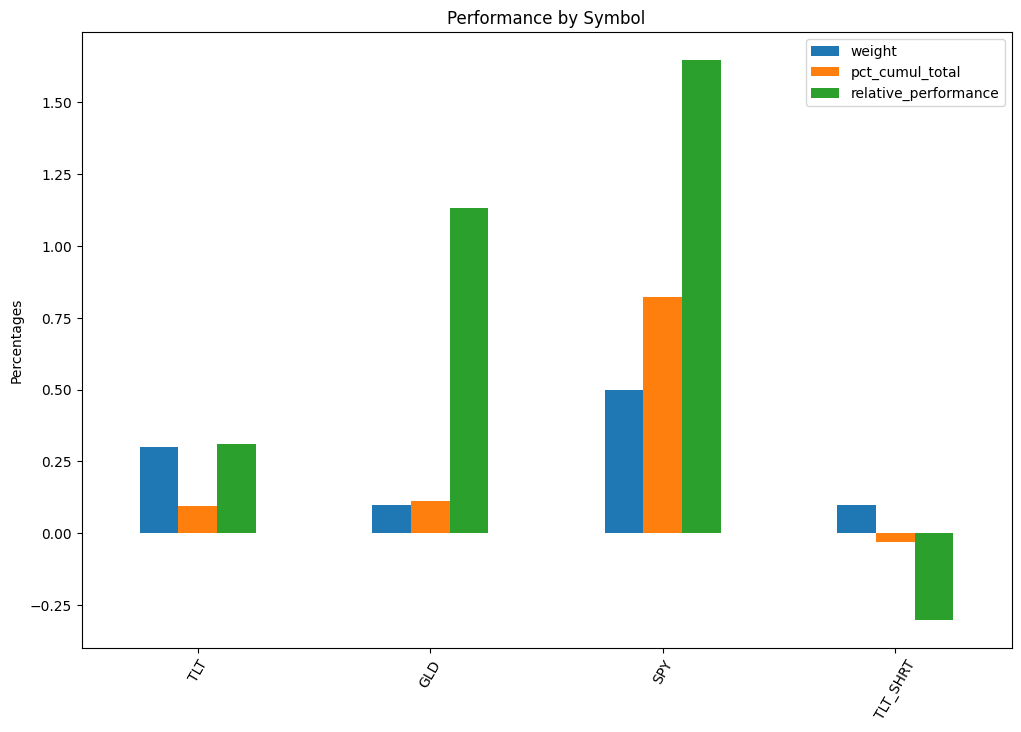

In [13]:
totals = portfolio.performance_per_symbol(portfolio_option)
totals

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

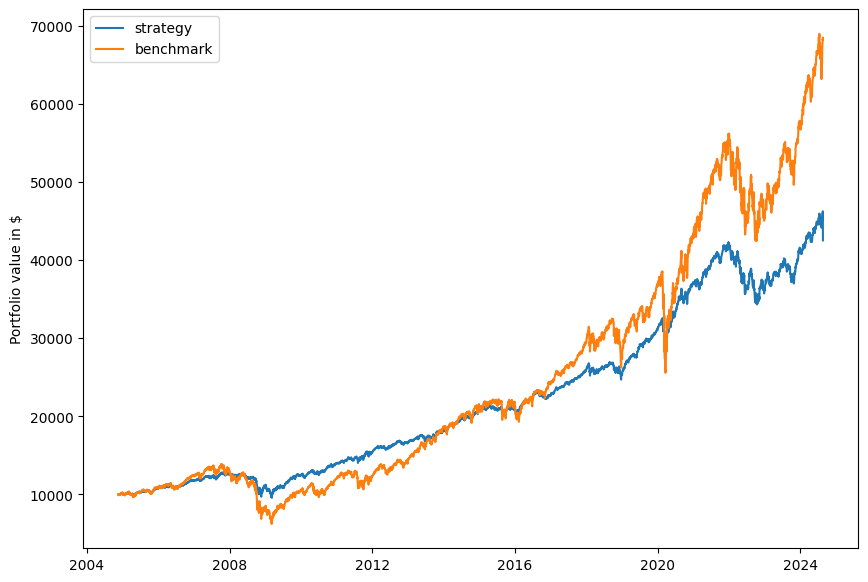

In [15]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

In [16]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$42,517.21","$68,436.40"
total_net_profit,"$32,517.21","$58,436.40"
gross_profit,"$37,428.75","$58,436.40"
gross_loss,"-$4,911.54",$0.00


,strategy,benchmark
annual_return_rate,7.60,10.22
max_closed_out_drawdown,-25.55,-55.03
annualized_return_over_max_drawdown,0.30,0.19
best_month,14.18,23.47
worst_month,-15.84,-30.95
sharpe_ratio,0.84,0.61
sortino_ratio,1.04,0.74
monthly_std,2.35,4.51
annual_std,8.31,16.28


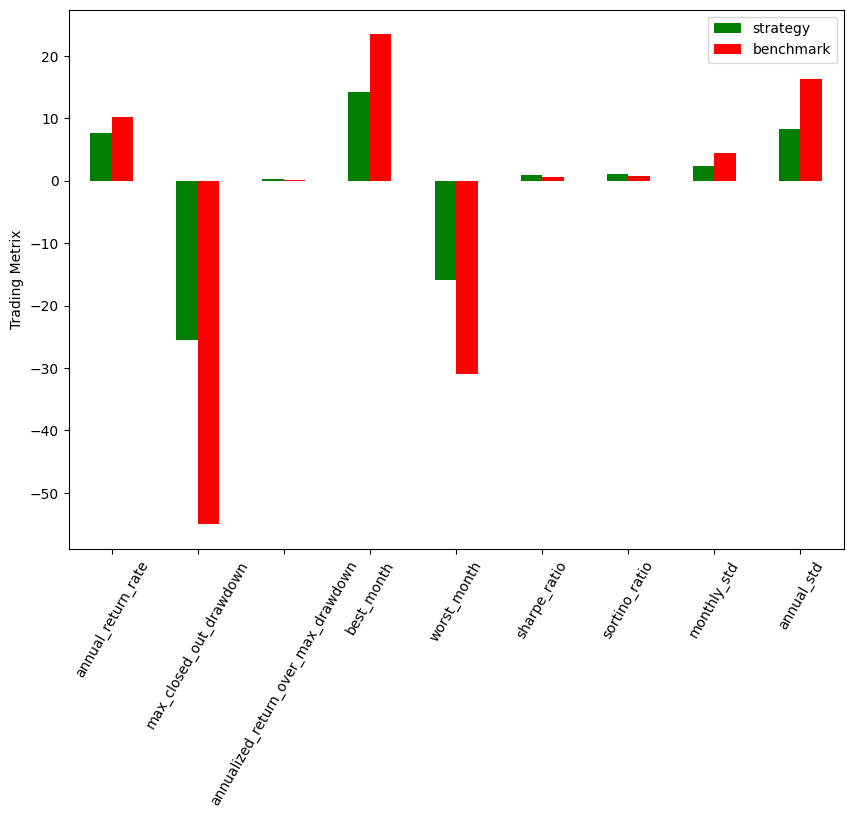

In [17]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df